<a href="https://colab.research.google.com/github/sciencenerd880/CIFAR10/blob/main/assignment2_taijingshen_q1_q2_q3(googel_colab)__v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIFAR-10  Assigment 2 | Applied Machine Learning
- Author: **Tai Jing Shen**

In [1]:
import tensorflow as tf
print(tf.__version__)

2.15.0


In [2]:
#import libraries and packages
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Activation, Conv2D, MaxPooling2D
from tensorflow.keras import models
import numpy as np
import os
import json

import random
seed_value = 2024

random.seed(seed_value)  # Python
np.random.seed(seed_value)  # NumPy
tf.random.set_seed(seed_value)  # TensorFlow

In [3]:
# check if got use GPU or not

is_gpu_available = tf.test.is_gpu_available(cuda_only=True)

# TensorFlow 2.x
gpus = tf.config.list_physical_devices('GPU')
is_gpu_available = len(gpus) > 0

print(f"Is a GPU available: {is_gpu_available}")

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Is a GPU available: False


In [4]:
# Load the data, will take some time sinze its quite big
(X_train,y_train) , (X_test, y_test) = cifar10.load_data()

Basic EDA to see the data

- other EDA tools for image: https://knowyourdata-tfds.withgoogle.com/#tab=STATS&dataset=cifar10

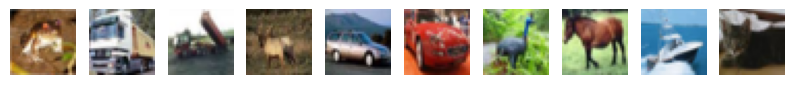

In [5]:
# Plot the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(10,10))
for i in range(10):
    axes[i].imshow(X_train[i])
    axes[i].axis('off')
plt.show()

In [6]:
# Check the shape and type of the data
print('num of samples x height x width x channels')
print('shape of train dataset is:', X_train.shape,type(X_train))
print('shape of test dataset is:', X_test.shape,type(X_test))

num of samples x height x width x channels
shape of train dataset is: (50000, 32, 32, 3) <class 'numpy.ndarray'>
shape of test dataset is: (10000, 32, 32, 3) <class 'numpy.ndarray'>


In [7]:
unique, counts = np.unique(y_train, return_counts=True)
print('num of classes: ', len(unique), 'classes->', unique)
print("train set class distribution is:", dict(zip(unique, counts)))
unique, counts = np.unique(y_test, return_counts=True)
print("test set class distribution is:", dict(zip(unique, counts)))

num of classes:  10 classes-> [0 1 2 3 4 5 6 7 8 9]
train set class distribution is: {0: 5000, 1: 5000, 2: 5000, 3: 5000, 4: 5000, 5: 5000, 6: 5000, 7: 5000, 8: 5000, 9: 5000}
test set class distribution is: {0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


In [8]:
#copy out original first, in case
X_train_orig = X_train.copy()
X_test_orig = X_test.copy()

# **[Question 1]  Data Normalizaton (4 marks)**


> As per question to normalize the data, since this is based on tensorflow implementation, then we will implement the method 1:

> (1) Normalization to [0,1]: This method involves scaling the pixel values of the images to fall within the [0,1] range, using Min-Max Scaling:
$$
X_{\text{new}} = \frac{X - X_{\min}}{X_{\max} - X_{\min}}
$$

In [9]:
# Calculate the min and max deriving from the training set. Should not use statistics from test set to avoid data leakage
X_min = X_train.min(axis=0)
X_max = X_train.max(axis=0)

def _normalize(data, X_min, X_max):
    #based on tensorflow documentation, the formula to normalize is (data - X_min) / (X_max - X_min)
    # but divide by 255 also will work
    return (data - X_min) / (X_max - X_min)

# Normalize both the training and test sets using these statistics
X_train_n = _normalize(X_train, X_min, X_max)
X_test_n = _normalize(X_test, X_min, X_max)

In [10]:
#convert the data to float32 and normalize it
def preprocess(df):
    '''
    output:
    the flattened data with 2 dimensions (number of instances, height*width*channels)
    each instance is a 1D array or vector of the image pixels or image features
    for the use of MLP since cannnot take in 2D array
    '''
    df = df.astype('float32')
    #flatten the images
    height, width, channels = df.shape[1], df.shape[2], df.shape[3]
    return df.reshape(-1, height*width*channels)

In [11]:
#preprocess the data
X_train_p = preprocess(X_train_n)
X_test_p = preprocess(X_test_n)

#since multiplying height width channels give 3072, lets check if its correct before proceeding
print('shape of preprocessed train dataset is:', X_train_p.shape,type(X_train_p))
print('shape of preprocessed test dataset is:', X_test_p.shape,type(X_test_p))
num_classes = len(np.unique(y_train))

shape of preprocessed train dataset is: (50000, 3072) <class 'numpy.ndarray'>
shape of preprocessed test dataset is: (10000, 3072) <class 'numpy.ndarray'>


# **[Question 2]  Multi-Layer Perceptron (10 marks)**

- Objective: Build and train a 'Multi-Layer Perceptron (MLP)' to classify images from the CIFAR-10 dataset, and achieve >50% accuracy.

#### Architectures to Try

Experiment with the following MLP architectures, incorporating the specified activation functions:

1. **One Hidden Layer Architecture** aka mlp_1
   - **Hidden Layer**: 128 neurons
   - **Activation Function**: ReLU
   - **Output Layer Activation**: Softmax (for multi-class classification)

2. **Larger Single Hidden Layer Architecture** aka mlp_2
   - **Hidden Layer**: 256 neurons
   - **Activation Function**: ReLU
   - **Output Layer Activation**: Softmax (for multi-class classification)

3. **Two Hidden Layers Architecture** aka mlp_3
   - **First Hidden Layer**: 256 neurons
   - **Second Hidden Layer**: 128 neurons
   - **Activation Function for Both Layers**: ReLU
   - **Output Layer Activation**: Softmax (for multi-class classification)

In [12]:
mlp_1 = tf.keras.models.Sequential([
    Flatten(input_shape= X_train_p.shape[1:]), #based on flattened input size
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
    ])

mlp_2 = tf.keras.models.Sequential([
    Flatten(input_shape=X_train_p.shape[1:]),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
    ])

mlp_3 = tf.keras.models.Sequential([
    Flatten(input_shape=X_train_p.shape[1:]),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
    ])

In [13]:
def train_and_evaluate(models, model_names, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate):
    """
    Trains multiple models and plots their training history.

    :param models: List of Keras model instances
    :param model_names: List of model names as strings
    :param X_train: Training data features
    :param y_train: Training data labels
    :param X_val: Validation data features
    :param y_val: Validation data labels
    :param epochs: Number of epochs to train each model
    :param batch_size: Batch size for training
    :param learning_rate: Learning rate for the optimizer

    :return: A dictionary containing the history of each model
    """
    history_dict = {}

    # Create an Adam  optimizer instance with the desired learning rate
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    for model, name in zip(models, model_names):
        print(f"Training {name}...")
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model and store the history
        history = model.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(X_val, y_val),
                            verbose=1)

        history_dict[name] = history.history

        # Save the weights
        model.save_weights(f'{name}_weights.h5')

        # Plot training and validation accuracy
        plt.figure(figsize=(10, 4))

        # Plot training & validation accuracy values
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title(f'{name} - Accuracy')
        plt.ylabel('Accuracy')
        plt.ylim(bottom=0)  # Set the bottom of the y-axis to 0
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')

        # Plot training & validation loss values
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title(f'{name} - Loss')
        plt.ylabel('Loss')
        plt.ylim(bottom=0)  # Set the bottom of the y-axis to 0
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Val'], loc='upper left')

        plt.tight_layout()
        plt.show()

        print(f"Training {name} completed.\n\n")

    return history_dict

In [14]:
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

def train_and_evaluate2(models, model_names, X_train, y_train, X_val, y_val, epochs, batch_size, learning_rate):
    """
    Trains multiple models and plots their training history.

    :param models: List of TensorFlow/Keras model instances.
    :param model_names: List of model names as strings.
    :param X_train: Training data features.
    :param y_train: Training data labels, one-hot encoded for 'categorical_crossentropy'.
    :param X_val: Validation data features.
    :param y_val: Validation data labels, one-hot encoded for 'categorical_crossentropy'.
    :param epochs: Number of epochs to train each model.
    :param batch_size: Batch size for training.
    :param learning_rate: Learning rate for the optimizer.

    :return: A dictionary containing the history of each model.
    """
    history_dict = {}

    for model, name in zip(models, model_names):
        print(f"Training {name}...")
        optimizer = Adam(learning_rate=learning_rate)
        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

        # Train the model and store the history
        history = model.fit(X_train, y_train,
                            batch_size=batch_size,
                            epochs=epochs,
                            validation_data=(X_val, y_val),
                            verbose=1)

        history_dict[name] = history.history

        # Plotting
        plt.figure(figsize=(12, 5))

        # Accuracy plot
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title(f'{name} Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.ylim([0, 1])

        # Loss plot
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f'{name} Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.ylim([0, max(max(history.history['loss']), max(history.history['val_loss'])) * 1.1])

        plt.tight_layout()
        plt.show()

        print(f"Training {name} completed.\n")

    return history_dict

In [15]:
#perform one hot encoding to the target variables
y_train_p = to_categorical(y_train,10)
y_test_p = to_categorical(y_test,10)
#print the first 10 target variables to see how itll look like for the one hot encoding
for i in range(10):
    print(y_train_p[i])

[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


Training MLP_1...
Epoch 1/10
1563/1563 [==============================] - 15s 8ms/step - loss: 1.8898 - accuracy: 0.3223 - val_loss: 1.7514 - val_accuracy: 0.3761
Epoch 2/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.7459 - accuracy: 0.3757 - val_loss: 1.6862 - val_accuracy: 0.3965
Epoch 3/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6799 - accuracy: 0.4012 - val_loss: 1.7014 - val_accuracy: 0.3896
Epoch 4/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6419 - accuracy: 0.4125 - val_loss: 1.6659 - val_accuracy: 0.4129
Epoch 5/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6243 - accuracy: 0.4219 - val_loss: 1.6229 - val_accuracy: 0.4219
Epoch 6/10
1563/1563 [==============================] - 11s 7ms/step - loss: 1.6051 - accuracy: 0.4266 - val_loss: 1.5997 - val_accuracy: 0.4354
Epoch 7/10
1563/1563 [==============================] - 12s 8ms/step - loss: 1.5898 - accuracy: 0.4345 - val_los

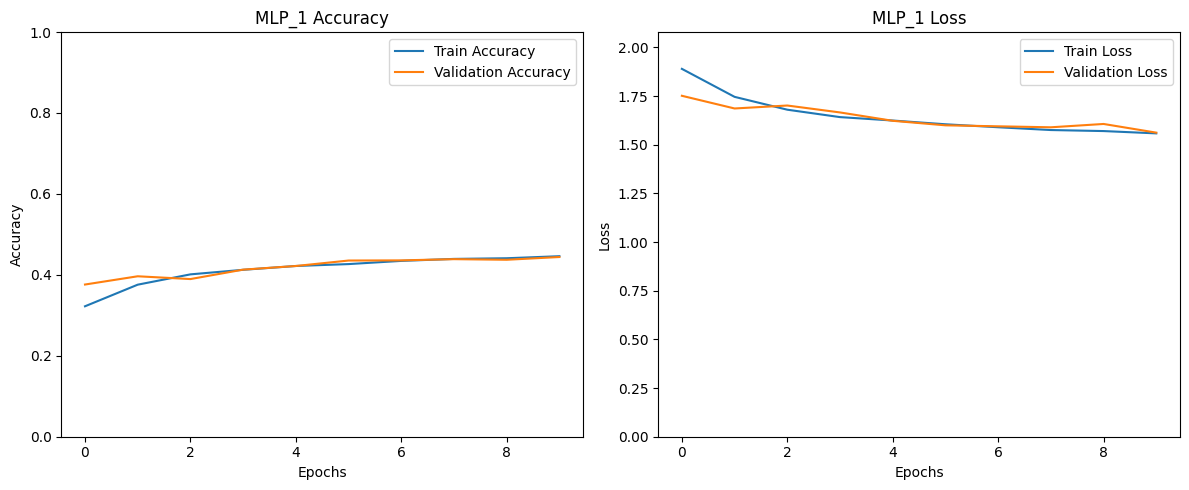

Training MLP_1 completed.

Training MLP_2...
Epoch 1/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.8839 - accuracy: 0.3250 - val_loss: 1.7752 - val_accuracy: 0.3682
Epoch 2/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.7254 - accuracy: 0.3822 - val_loss: 1.6762 - val_accuracy: 0.3890
Epoch 3/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.6538 - accuracy: 0.4097 - val_loss: 1.6684 - val_accuracy: 0.4024
Epoch 4/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.6190 - accuracy: 0.4201 - val_loss: 1.6793 - val_accuracy: 0.4042
Epoch 5/10
1563/1563 [==============================] - 17s 11ms/step - loss: 1.5913 - accuracy: 0.4328 - val_loss: 1.6023 - val_accuracy: 0.4316
Epoch 6/10
1563/1563 [==============================] - 19s 12ms/step - loss: 1.5711 - accuracy: 0.4420 - val_loss: 1.5824 - val_accuracy: 0.4338
Epoch 7/10
1563/1563 [==============================] - 18s 12ms/step - loss: 1

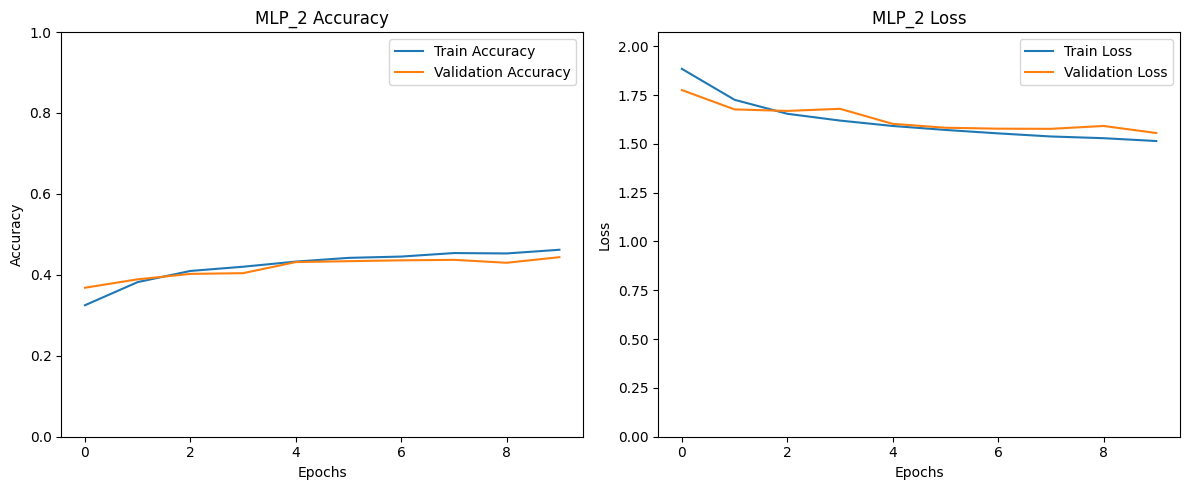

Training MLP_2 completed.

Training MLP_3...
Epoch 1/10
1563/1563 [==============================] - 23s 14ms/step - loss: 1.8567 - accuracy: 0.3285 - val_loss: 1.7086 - val_accuracy: 0.3874
Epoch 2/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.6739 - accuracy: 0.4005 - val_loss: 1.5912 - val_accuracy: 0.4297
Epoch 3/10
1563/1563 [==============================] - 21s 14ms/step - loss: 1.5951 - accuracy: 0.4290 - val_loss: 1.5800 - val_accuracy: 0.4323
Epoch 4/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1.5468 - accuracy: 0.4476 - val_loss: 1.5266 - val_accuracy: 0.4566
Epoch 5/10
1563/1563 [==============================] - 23s 15ms/step - loss: 1.5127 - accuracy: 0.4589 - val_loss: 1.4956 - val_accuracy: 0.4719
Epoch 6/10
1563/1563 [==============================] - 20s 13ms/step - loss: 1.4843 - accuracy: 0.4676 - val_loss: 1.5216 - val_accuracy: 0.4591
Epoch 7/10
1563/1563 [==============================] - 22s 14ms/step - loss: 1

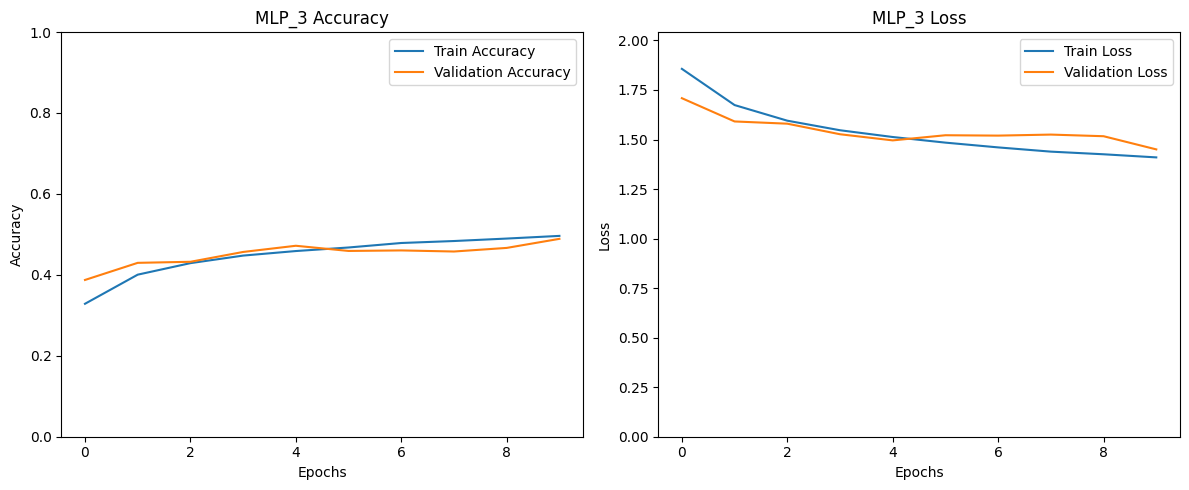

Training MLP_3 completed.



In [16]:
#hyperparameters
batch_size = 32
learning_rate = 0.001
epochs = 10

optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

#baseline models to try as per question
baseline_models = [mlp_1, mlp_2, mlp_3]
model_names = ['MLP_1', 'MLP_2', 'MLP_3']  # Replace with actual model names

'''
histories = train_and_evaluate(baseline_models, model_names, X_train_p, y_train_p, X_test_p, y_test_p,
                               epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)
'''
histories = train_and_evaluate2(baseline_models, model_names, X_train_p, y_train_p, X_test_p, y_test_p,
                               epochs=10, batch_size=32, learning_rate=0.001)



> #### Observations
- It seems like MLP 3 with more 2 hidden layers perform the best out of all three in terms of accuracy and its losses
- Decided to use MLP 3 and stretch the epochs from 10 to 25 and see how it performs over time, and see if its possible to reach >50% since it it very close right now

In [18]:
mlp_experiment = tf.keras.models.Sequential([
    Flatten(input_shape=X_train_p.shape[1:]),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
    ])

Training MLP_EXP...
Epoch 1/25
1563/1563 [==============================] - 23s 15ms/step - loss: 1.8697 - accuracy: 0.3273 - val_loss: 1.7119 - val_accuracy: 0.3929
Epoch 2/25
1563/1563 [==============================] - 20s 13ms/step - loss: 1.6822 - accuracy: 0.3972 - val_loss: 1.6097 - val_accuracy: 0.4235
Epoch 3/25
1563/1563 [==============================] - 21s 13ms/step - loss: 1.6000 - accuracy: 0.4277 - val_loss: 1.5860 - val_accuracy: 0.4385
Epoch 4/25
1563/1563 [==============================] - 21s 14ms/step - loss: 1.5533 - accuracy: 0.4423 - val_loss: 1.5739 - val_accuracy: 0.4445
Epoch 5/25
1563/1563 [==============================] - 21s 14ms/step - loss: 1.5196 - accuracy: 0.4584 - val_loss: 1.5145 - val_accuracy: 0.4636
Epoch 6/25
1563/1563 [==============================] - 24s 15ms/step - loss: 1.4902 - accuracy: 0.4688 - val_loss: 1.5281 - val_accuracy: 0.4557
Epoch 7/25
1563/1563 [==============================] - 22s 14ms/step - loss: 1.4692 - accuracy: 0.4760 

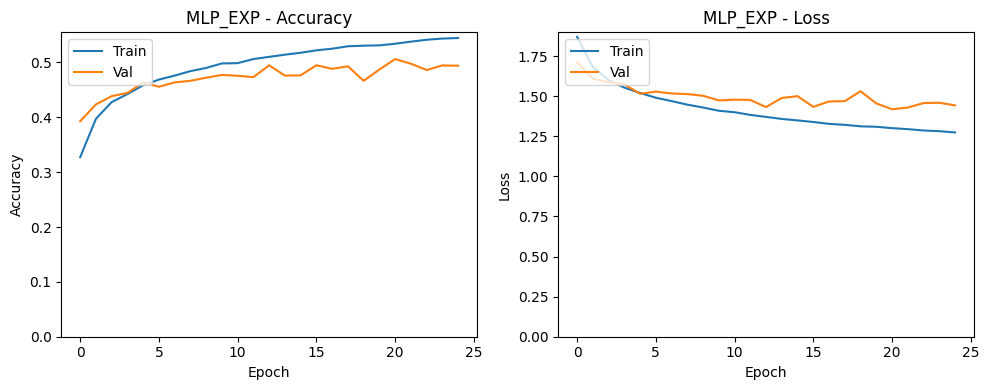

Training MLP_EXP completed.




In [19]:
#hyperparameters
batch_size = 32
learning_rate = 0.001
epochs = 25 #previously was 10

optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

#model chosen to be trained
models = [mlp_experiment]
model_names = ['MLP_EXP']  # Replace with actual model names

histories_experiment = train_and_evaluate(models, model_names, X_train_p, y_train_p, X_test_p, y_test_p,
                               epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)

With 25 epochs, we see that the deeper MLP (mlp_3) did increase the training accuracy or reduce the training loss over epochs, but unfortunately, there isn't much improvement in the validation accuracy or reduction in validation loss over epochs. The gap between both train and validation also seems to be widening, showing that it is diverging/overfitting in this case.

> we introduce dropout as a form of regularisation to prevent overfitting. Dropout refers to taking a fraction of the neurons will be randomly set to zero during each training batch

> i will also increase the first dense layer from 256 neurons to 512 neurons instead in hopes to capture more complex pattern at the start of the network

In [20]:
mlp_final = Sequential([
    Flatten(input_shape=X_train_p.shape[1:]),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dropout(0.1),  # Add dropout after the second dense layer
    Dense(num_classes, activation='softmax')
])

Training MLP_FINAL...
Epoch 1/25
1563/1563 [==============================] - 39s 24ms/step - loss: 1.9819 - accuracy: 0.2638 - val_loss: 1.8206 - val_accuracy: 0.3476
Epoch 2/25
1563/1563 [==============================] - 34s 22ms/step - loss: 1.7680 - accuracy: 0.3640 - val_loss: 1.6403 - val_accuracy: 0.4199
Epoch 3/25
1563/1563 [==============================] - 38s 24ms/step - loss: 1.6715 - accuracy: 0.4007 - val_loss: 1.6495 - val_accuracy: 0.4129
Epoch 4/25
1563/1563 [==============================] - 35s 23ms/step - loss: 1.6196 - accuracy: 0.4202 - val_loss: 1.5674 - val_accuracy: 0.4442
Epoch 5/25
1563/1563 [==============================] - 35s 22ms/step - loss: 1.5804 - accuracy: 0.4374 - val_loss: 1.5497 - val_accuracy: 0.4487
Epoch 6/25
1563/1563 [==============================] - 34s 22ms/step - loss: 1.5456 - accuracy: 0.4488 - val_loss: 1.5238 - val_accuracy: 0.4601
Epoch 7/25
1563/1563 [==============================] - 35s 23ms/step - loss: 1.5198 - accuracy: 0.457

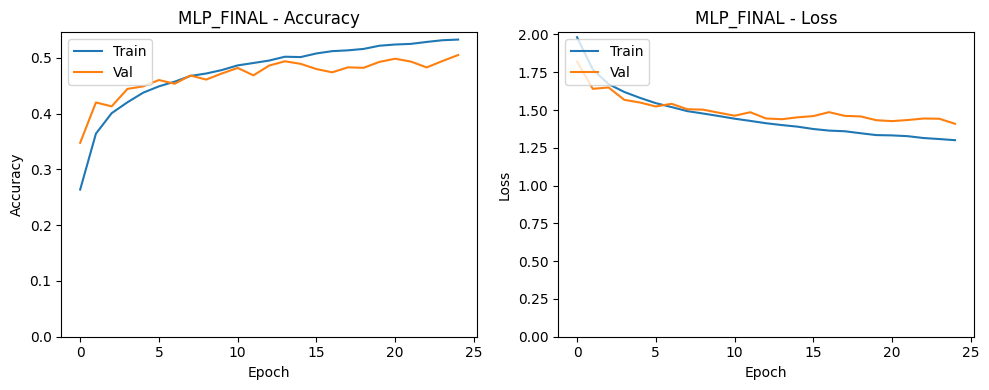

Training MLP_FINAL completed.




In [21]:
#hyperparameters
batch_size = 32
learning_rate = 0.001
epochs = 25 #previously was 10

optimizer = 'adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']

#model chosen to be trained
models = [mlp_final]
model_names = ['MLP_FINAL']  # Replace with actual model names

histories_experiment = train_and_evaluate(models, model_names, X_train_p, y_train_p, X_test_p, y_test_p,
                               epochs=epochs, batch_size=batch_size, learning_rate=learning_rate)

Observation: With the same hyperparameters set such as batch size of 32, learning rate of 0.0001 and also 25 epochs, the validation accuracy is able to achieve 50% (val acc = 0.5081) as shown in the output, the only change that i did are:

- increasing the number of neurons at the first dense layer to capture complex pattern at the start
- added dropout as a form of regularisation to prevent overfitting which was seen especially on the first 3 baseline models and also as suggested by the question.

Epoch 25/25
1563/1563 [==============================] - 3s 2ms/step - loss: 1.2895 - accuracy: 0.5374 - val_loss: 1.4141 - val_accuracy: **0.5081**

`**Overall Summary:**`

***Opportunity to further optimise***

Did not perform grid search CV to tune the hyperparameters as i think that i would like to build an incremental model right from the start (or scratch) to get a feel of the difficulty in the dataset and also the intuition of modifying the architecture in the most minute way to achieve a better performance than the previous

But I am happy to be able to achieve the performance target of 0.5 with the knowledge gained from the theory/lecture and apply it by myself than just letting the "automation grid search" to do the work

# **[Question 3]  Convolutional Neural Network (10 marks)**

- Objective: Develop a Convolutional Neural Network (CNN) to improve the classification performance on the CIFAR-10 dataset, and achieve >70% accuracy

In [22]:
# reshape the data back to its original shape height x width x channels
X_train_p = X_train_p.reshape(-1, 32, 32, 3)  # Reshape from (batch_size, 3072) to (batch_size, 32, 32, 3)
X_test_p = X_test_p.reshape(-1, 32, 32, 3)    # Same for the test set

In [23]:
print(X_train_p.shape)
print(X_test_p.shape)

(50000, 32, 32, 3)
(10000, 32, 32, 3)


In [24]:
cnn = Sequential([
    # Conv Block 1
    Conv2D(32, (3, 3), padding='same', input_shape=X_train_p.shape[1:]),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),

    # Conv Block 2
    Conv2D(64, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),

    # Conv Block 3
    Conv2D(128, (3, 3), padding='same'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),

    # Fully Connected Layers
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax'),
])

cnn.summary()



Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (Batch  (None, 32, 32, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 batch_normalization_1 (Bat  (None, 30, 30, 32)        128       
 chNormalization)                                                
                                                                 
 activation_1 (Activation)   (None, 30, 30, 32)       

In [25]:
# Compile the CNN model first
cnn.compile(optimizer='adam',  # Or another optimizer of your choice
            loss='categorical_crossentropy',  # Or 'sparse_categorical_crossentropy' if your labels are integers
            metrics=['accuracy'])

# Now you can train the model after compilation
history_cnn = cnn.fit(X_train_p, y_train_p,
                      batch_size=32,
                      epochs=25,
                      validation_data=(X_test_p, y_test_p),
                      verbose=1)


Epoch 1/25
1563/1563 [==============================] - 293s 185ms/step - loss: 1.7180 - accuracy: 0.3670 - val_loss: 1.3510 - val_accuracy: 0.5112
Epoch 2/25
1563/1563 [==============================] - 293s 188ms/step - loss: 1.3122 - accuracy: 0.5356 - val_loss: 1.1114 - val_accuracy: 0.6073
Epoch 3/25
1563/1563 [==============================] - 293s 187ms/step - loss: 1.1212 - accuracy: 0.6118 - val_loss: 1.0325 - val_accuracy: 0.6458
Epoch 4/25
1563/1563 [==============================] - 298s 191ms/step - loss: 0.9872 - accuracy: 0.6588 - val_loss: 0.8310 - val_accuracy: 0.7170
Epoch 5/25
 443/1563 [=======>......................] - ETA: 3:16 - loss: 0.9127 - accuracy: 0.6921

KeyboardInterrupt: 

In [ ]:
#plot the cnn accuracy and loss
plt.figure(figsize=(10, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'])
plt.plot(history_cnn.history['val_accuracy'])
plt.title('CNN - Accuracy')
plt.ylabel('Accuracy')
plt.ylim(bottom=0)  # Set the bottom of the y-axis to 0
plt.xlabel('Epoch')

plt.legend(['Train', 'Val'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'])
plt.plot(history_cnn.history['val_loss'])
plt.title('CNN - Loss')
plt.ylabel('Loss')
plt.ylim(bottom=0)  # Set the bottom of the y-axis to 0
plt.xlabel('Epoch')

plt.legend(['Train', 'Val'], loc='upper left')

plt.tight_layout()
plt.show()